In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# === Paths (edit as needed) ===
DATA_DIR   = Path(r"S:\stock project\archive")           # folder with your *_5minute.csv stock files
INDEX_FILE = Path(r"S:\stock project\NIFTY50_index_5min_2023_2025.csv")  # optional benchmark

# === Analysis window ===
START_DATE = "2023-01-01"
END_DATE   = "2025-12-31"

# === Strategy parameters (your Pine) ===
EMA_LEN       = 200         # EMA 200
EMA_FAST_LEN  = 5           # EMA 5 (for angle)
TP_PCT        = 0.36        # +36% take-profit
SL_PCT        = 0.16        # -16% stop-loss

# === Optional: restrict to current NIFTY50 list ===
NIFTY50_LIST = [
    "ADANIENT","ADANIPORTS","APOLLOHOSP","ASIANPAINT","AXISBANK","BAJAJ-AUTO",
    "BAJFINANCE","BAJAJFINSV","BPCL","BHARTIARTL","BRITANNIA","CIPLA","COALINDIA",
    "DIVISLAB","DRREDDY","EICHERMOT","GRASIM","HCLTECH","HDFCBANK","HDFCLIFE",
    "HEROMOTOCO","HINDALCO","HINDUNILVR","ICICIBANK","INDUSINDBK","INFY","ITC",
    "JSWSTEEL","KOTAKBANK","LT","MARUTI","NESTLEIND","NTPC","ONGC","POWERGRID",
    "RELIANCE","SBILIFE","SBIN","SUNPHARMA","TATACONSUM","TATAMOTORS","TATASTEEL",
    "TCS","TECHM","TITAN","ULTRACEMCO","WIPRO"
]


In [2]:
def load_data(path: Path, start=START_DATE, end=END_DATE) -> pd.DataFrame:
    """Read CSV → OHLCV with datetime index, sliced to [start, end]."""
    df = pd.read_csv(path)
    # detect datetime column
    date_col = None
    for c in df.columns:
        if c.lower() in ["datetime","date","timestamp","time"]:
            date_col = c
            break
    if date_col is None:
        date_col = df.columns[0]
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(by=date_col)
    df = df[(df[date_col] >= start) & (df[date_col] <= end)]
    df = df.rename(columns=str.lower)
    return df.set_index("date")[["open","high","low","close","volume"]]

# Quick test: load one file
one_file = next(DATA_DIR.glob("*.csv"))
df5 = load_data(one_file)
print("Loaded:", one_file.name, "Shape:", df5.shape)
df5.head()


Loaded: ABB_5minute.csv Shape: (48166, 5)


,open,high,low,close,volume
date,,,,,
2023-01-02 09:15:00,2685.00,2696.50,2683.30,2686.60,3288
2023-01-02 09:20:00,2687.25,2692.65,2679.85,2682.20,3194
2023-01-02 09:25:00,2683.15,2683.75,2666.90,2669.25,6615
2023-01-02 09:30:00,2669.25,2677.85,2662.50,2671.55,2121
2023-01-02 09:35:00,2673.05,2679.05,2669.95,2673.15,2275


In [3]:
def resample_ohlcv(df: pd.DataFrame, rule: str) -> pd.DataFrame:
    """
    Resample to a higher timeframe.
    Use '10min' for 10-minute, '15min' for 15-minute, etc.
    """
    agg = {"open":"first","high":"max","low":"min","close":"last","volume":"sum"}
    return df.resample(rule, label="right", closed="right").agg(agg).dropna()

# Create 10-min & 15-min from 5-min
df10 = resample_ohlcv(df5, "10min")   # <-- 10-min timeframe
df15 = resample_ohlcv(df5, "15min")   # <-- 15-min timeframe

print("5min:", df5.shape, "10min:", df10.shape, "15min:", df15.shape)
df10.head()


5min: (48166, 5) 10min: (24408, 5) 15min: (16703, 5)


,open,high,low,close,volume
date,,,,,
2023-01-02 09:20:00,2685.00,2696.50,2679.85,2682.20,6482
2023-01-02 09:30:00,2683.15,2683.75,2662.50,2671.55,8736
2023-01-02 09:40:00,2673.05,2679.05,2666.30,2670.05,3873
2023-01-02 09:50:00,2670.60,2683.90,2666.80,2682.05,4820
2023-01-02 10:00:00,2682.05,2688.55,2680.70,2685.05,3829


In [4]:
def ema(series: pd.Series, n: int) -> pd.Series:
    return series.ewm(span=n, adjust=False).mean()

def backtest(df: pd.DataFrame,
             ema_len=EMA_LEN,
             tp_pct=TP_PCT,
             sl_pct=SL_PCT,
             ema_fast_len=EMA_FAST_LEN):
    """
    Long-only strategy:
      ENTRY  = (close crosses ABOVE EMA200) AND (EMA5 angle > 5°)
      EXIT   = TP +36%  OR  SL -16%   (first touch on the same bar by H/L)
      One position at a time, evaluate entries on close.
    """
    d = df.copy()
    d["ema200"]   = ema(d["close"], ema_len)
    d["ema_fast"] = ema(d["close"], ema_fast_len)
    d["slope"]    = d["ema_fast"] - d["ema_fast"].shift(1)
    d["angle"]    = np.degrees(np.arctan(d["slope"]))

    # ENTRY condition (crossover at close)
    d["longSignal"] = (d["close"].shift(1) <= d["ema200"].shift(1)) & (d["close"] > d["ema200"])

    # Sim loop
    trades = []
    position = 0
    entry_price = None
    entry_time  = None

    for ts, row in d.iterrows():
        if position == 0:
            # ---- ENTRY: crossover + angle > 5°
            if bool(row["longSignal"]) and row["angle"] > 5:
                position    = 1
                entry_price = float(row["close"])  # enter at close
                entry_time  = ts
        else:
            # ---- EXIT logic (THIS IS THE 36% / 16% PART) ----
            tp = entry_price * (1 + tp_pct)   # +36% take-profit
            sl = entry_price * (1 - sl_pct)   # -16% stop-loss
            hit_tp = row["high"] >= tp
            hit_sl = row["low"]  <= sl

            if hit_tp and not hit_sl:
                exit_price, reason = tp, "TP"
            elif hit_sl and not hit_tp:
                exit_price, reason = sl, "SL"
            elif hit_tp and hit_sl:
                # both touched in same bar; tie-break by closer to open
                dist_tp = abs(tp - row["open"])
                dist_sl = abs(row["open"] - sl)
                if dist_sl < dist_tp:
                    exit_price, reason = sl, "SL*"
                else:
                    exit_price, reason = tp, "TP*"
            else:
                continue

            trades.append({
                "Entry Time": entry_time,
                "Entry Price": entry_price,
                "Exit Time": ts,
                "Exit Price": float(exit_price),
                "PnL": float(exit_price - entry_price),
                "Exit": reason
            })
            position = 0
            entry_price = None
            entry_time  = None

    trades_df = pd.DataFrame(trades)

    # Metrics after each run
    if trades_df.empty:
        metrics = {
            "P&L": 0.0, "Max Drawdown": 0.0, "Max Drawdown %": 0.0,
            "Number of Trades": 0, "Profitable Trades %": 0.0, "Profit Factor": np.nan
        }
        return trades_df, metrics

    pnl = trades_df["PnL"]
    total_pnl = pnl.sum()
    n_trades = len(trades_df)
    winners  = (pnl > 0).sum()
    gp = pnl[pnl > 0].sum()
    gl = -pnl[pnl < 0].sum()
    profit_factor = (gp / gl) if gl > 0 else np.inf

    equity = pnl.cumsum()
    peak   = equity.cummax()
    dd     = equity - peak
    max_dd = dd.min()
    dd_pct = (dd / peak.replace(0, np.nan)).min()
    dd_pct = float(dd_pct * 100) if pd.notna(dd_pct) else 0.0

    metrics = {
        "P&L": float(total_pnl),
        "Max Drawdown": float(max_dd),
        "Max Drawdown %": dd_pct,
        "Number of Trades": int(n_trades),
        "Profitable Trades %": round((winners / n_trades) * 100, 2) if n_trades else 0.0,
        "Profit Factor": float(profit_factor) if np.isfinite(profit_factor) else np.inf
    }
    return trades_df, metrics

# Run strategy on 5/10/15 for the sample file and see results right away
for tf, data in [("5min", df5), ("10min", df10), ("15min", df15)]:
    trades, metrics = backtest(data)
    print(f"Sample File: {one_file.name} | {tf} metrics ->", metrics)
    display(trades.head())


Sample File: ABB_5minute.csv | 5min metrics -> {'P&L': 2161.9559999999974, 'Max Drawdown': -2102.7840000000006, 'Max Drawdown %': -49.30626486022599, 'Number of Trades': 5, 'Profitable Trades %': np.float64(60.0), 'Profit Factor': 2.0281398374726063}


,Entry Time,Entry Price,Exit Time,Exit Price,PnL,Exit
0,2023-01-02 10:35:00,2686.5,2023-05-04 11:00:00,3653.640,967.140,TP
1,2023-05-15 14:10:00,3876.7,2024-02-22 09:40:00,5272.312,1395.612,TP
2,2024-02-26 11:15:00,5283.3,2024-05-08 15:00:00,7185.288,1901.988,TP
3,2024-05-09 15:25:00,7040.0,2025-01-28 10:35:00,5913.600,-1126.400,SL
4,2025-01-29 09:35:00,6102.4,2025-02-03 09:50:00,5126.016,-976.384,SL


Sample File: ABB_5minute.csv | 10min metrics -> {'P&L': -190.78000000000247, 'Max Drawdown': -4617.304000000001, 'Max Drawdown %': -104.30992806093455, 'Number of Trades': 7, 'Profitable Trades %': np.float64(42.86), 'Profit Factor': 0.9586815163134152}


,Entry Time,Entry Price,Exit Time,Exit Price,PnL,Exit
0,2023-01-02 09:50:00,2682.05,2023-05-04 11:00:00,3647.588,965.538,TP
1,2023-05-19 11:40:00,3885.05,2024-02-22 09:40:00,5283.668,1398.618,TP
2,2024-03-12 15:30:00,5728.80,2024-05-13 09:30:00,7791.168,2062.368,TP
3,2024-05-27 11:50:00,8350.95,2024-06-04 12:20:00,7014.798,-1336.152,SL
4,2024-06-06 10:50:00,8055.35,2024-11-14 09:20:00,6766.494,-1288.856,SL


Sample File: ABB_5minute.csv | 15min metrics -> {'P&L': -34.18800000000192, 'Max Drawdown': -4427.880000000001, 'Max Drawdown %': -100.77811553472573, 'Number of Trades': 7, 'Profitable Trades %': np.float64(42.86), 'Profit Factor': 0.9922789235480632}


,Entry Time,Entry Price,Exit Time,Exit Price,PnL,Exit
0,2023-01-02 10:45:00,2688.8,2023-05-04 12:45:00,3656.768,967.968,TP
1,2023-05-19 10:15:00,3870.1,2024-02-22 09:45:00,5263.336,1393.236,TP
2,2024-03-14 15:30:00,5645.8,2024-05-13 09:15:00,7678.288,2032.488,TP
3,2024-05-28 14:45:00,8263.0,2024-11-05 11:15:00,6940.920,-1322.080,SL
4,2024-11-11 11:45:00,7255.4,2025-01-13 15:30:00,6094.536,-1160.864,SL


In [5]:
import re

def symbol_from_filename(p: Path) -> str:
    # e.g. "TCS_5minute.csv", "TCS_5minutedata.csv" → "TCS"
    return re.split(r"_5min", p.stem, flags=re.I)[0]

files = sorted(DATA_DIR.glob("*.csv"))
symbol_map = {symbol_from_filename(p): p for p in files}

# choose symbols
if NIFTY50_LIST:
    symbols = [s for s in NIFTY50_LIST if s in symbol_map]
else:
    symbols = list(symbol_map.keys())

print("Running symbols:", len(symbols))
summary_rows = []
per_trade_logs = {}

for i, sym in enumerate(symbols, 1):
    print(f"[{i}/{len(symbols)}] {sym}")
    df5 = load_data(symbol_map[sym])

    datasets = {
        "5min": df5,                          # <-- 5-minute timeframe
        "10min": resample_ohlcv(df5, "10min"),# <-- 10-minute timeframe
        "15min": resample_ohlcv(df5, "15min") # <-- 15-minute timeframe
    }
    for tf, d in datasets.items():
        trades_df, metrics = backtest(d)      # exits are TP +36% / SL -16% (see function)
        trades_df["Symbol"]    = sym
        trades_df["Timeframe"] = tf
        per_trade_logs[(sym, tf)] = trades_df

        row = {"Stock": sym, "Timeframe": tf}
        row.update(metrics)
        summary_rows.append(row)

summary = pd.DataFrame(summary_rows, columns=[
    "Stock","Timeframe","P&L","Max Drawdown","Max Drawdown %","Number of Trades","Profitable Trades %","Profit Factor"
]).sort_values(["Stock","Timeframe"]).reset_index(drop=True)

print("DONE. Summary preview:")
summary.head(10)


Running symbols: 47
[1/47] ADANIENT
[2/47] ADANIPORTS
[3/47] APOLLOHOSP
[4/47] ASIANPAINT
[5/47] AXISBANK
[6/47] BAJAJ-AUTO
[7/47] BAJFINANCE
[8/47] BAJAJFINSV
[9/47] BPCL
[10/47] BHARTIARTL
[11/47] BRITANNIA
[12/47] CIPLA
[13/47] COALINDIA
[14/47] DIVISLAB
[15/47] DRREDDY
[16/47] EICHERMOT
[17/47] GRASIM
[18/47] HCLTECH
[19/47] HDFCBANK
[20/47] HDFCLIFE
[21/47] HEROMOTOCO
[22/47] HINDALCO
[23/47] HINDUNILVR
[24/47] ICICIBANK
[25/47] INDUSINDBK
[26/47] INFY
[27/47] ITC
[28/47] JSWSTEEL
[29/47] KOTAKBANK
[30/47] LT
[31/47] MARUTI
[32/47] NESTLEIND
[33/47] NTPC
[34/47] ONGC
[35/47] POWERGRID
[36/47] RELIANCE
[37/47] SBILIFE
[38/47] SBIN
[39/47] SUNPHARMA
[40/47] TATACONSUM
[41/47] TATAMOTORS
[42/47] TATASTEEL
[43/47] TCS
[44/47] TECHM
[45/47] TITAN
[46/47] ULTRACEMCO
[47/47] WIPRO
DONE. Summary preview:


,Stock,Timeframe,P&L,Max Drawdown,Max Drawdown %,Number of Trades,Profitable Trades %,Profit Factor
0,ADANIENT,10min,-652.696,-1486.192,-178.308234,9,33.33,0.759691
1,ADANIENT,15min,212.784,-894.616,-80.785263,7,42.86,1.114852
2,ADANIENT,5min,-714.020,-979.016,-369.445577,9,33.33,0.732072
3,ADANIPORTS,10min,472.972,-219.184,-31.666850,5,60.00,2.349036
4,ADANIPORTS,15min,305.744,-412.928,-57.457088,6,50.00,1.561583
5,ADANIPORTS,5min,271.572,-192.616,-234.690595,6,50.00,1.624407
6,APOLLOHOSP,10min,1613.934,0.000,0.000000,1,100.00,inf
7,APOLLOHOSP,15min,1613.934,0.000,0.000000,1,100.00,inf
8,APOLLOHOSP,5min,1608.534,0.000,0.000000,1,100.00,inf
9,ASIANPAINT,10min,-487.544,0.000,-0.000000,1,0.00,0.000000


In [9]:
!pip install xlsxwriter


In [10]:
# Aggregate view by timeframe
agg_tf = summary.groupby("Timeframe", as_index=False).agg({
    "P&L":"sum",
    "Max Drawdown":"min",
    "Number of Trades":"sum",
    "Profitable Trades %":"mean",
    "Profit Factor":"mean"
})
print("Aggregate by timeframe:")
agg_tf

# Save to Excel + CSV
OUTPUT_DIR = Path(r"S:\stock project\outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

excel_path = OUTPUT_DIR / "nifty_strategy_results.xlsx"
csv_path   = OUTPUT_DIR / "summary.csv"

with pd.ExcelWriter(excel_path, engine="xlsxwriter") as w:

    summary.round(4).to_excel(w, sheet_name="SUMMARY", index=False)
    agg_tf.round(4).to_excel(w, sheet_name="AGGREGATE_BY_TF", index=False)
    for (sym, tf), df in per_trade_logs.items():
        sheet = f"{sym}_{tf}"[:31]
        (df if not df.empty else pd.DataFrame(columns=[
            "Entry Time","Entry Price","Exit Time","Exit Price","PnL","Exit","Symbol","Timeframe"
        ])).to_excel(w, sheet_name=sheet, index=False)

summary.to_csv(csv_path, index=False)
print("Saved:", excel_path)
print("Saved:", csv_path)


Aggregate by timeframe:
Saved: S:\stock project\outputs\nifty_strategy_results.xlsx
Saved: S:\stock project\outputs\summary.csv


In [1]:
import pandas as pd

summary = pd.read_csv(r"S:\stock project\outputs\summary.csv")
summary.head()

,Stock,Timeframe,P&L,Max Drawdown,Max Drawdown %,Number of Trades,Profitable Trades %,Profit Factor
0,ADANIENT,10min,-652.696,-1486.192,-178.308234,9,33.33,0.759691
1,ADANIENT,15min,212.784,-894.616,-80.785263,7,42.86,1.114852
2,ADANIENT,5min,-714.020,-979.016,-369.445577,9,33.33,0.732072
3,ADANIPORTS,10min,472.972,-219.184,-31.666850,5,60.00,2.349036
4,ADANIPORTS,15min,305.744,-412.928,-57.457088,6,50.00,1.561583


In [2]:
agg_tf = summary.groupby("Timeframe", as_index=False).agg({
    "P&L":"sum",
    "Max Drawdown":"min",
    "Number of Trades":"sum",
    "Profitable Trades %":"mean",
    "Profit Factor":"mean"
})
agg_tf


,Timeframe,P&L,Max Drawdown,Number of Trades,Profitable Trades %,Profit Factor
0,10min,23543.0956,-4946.24,134,58.581702,inf
1,15min,22169.9732,-4742.80,125,59.777447,inf
2,5min,23611.9376,-4964.56,139,59.042553,inf


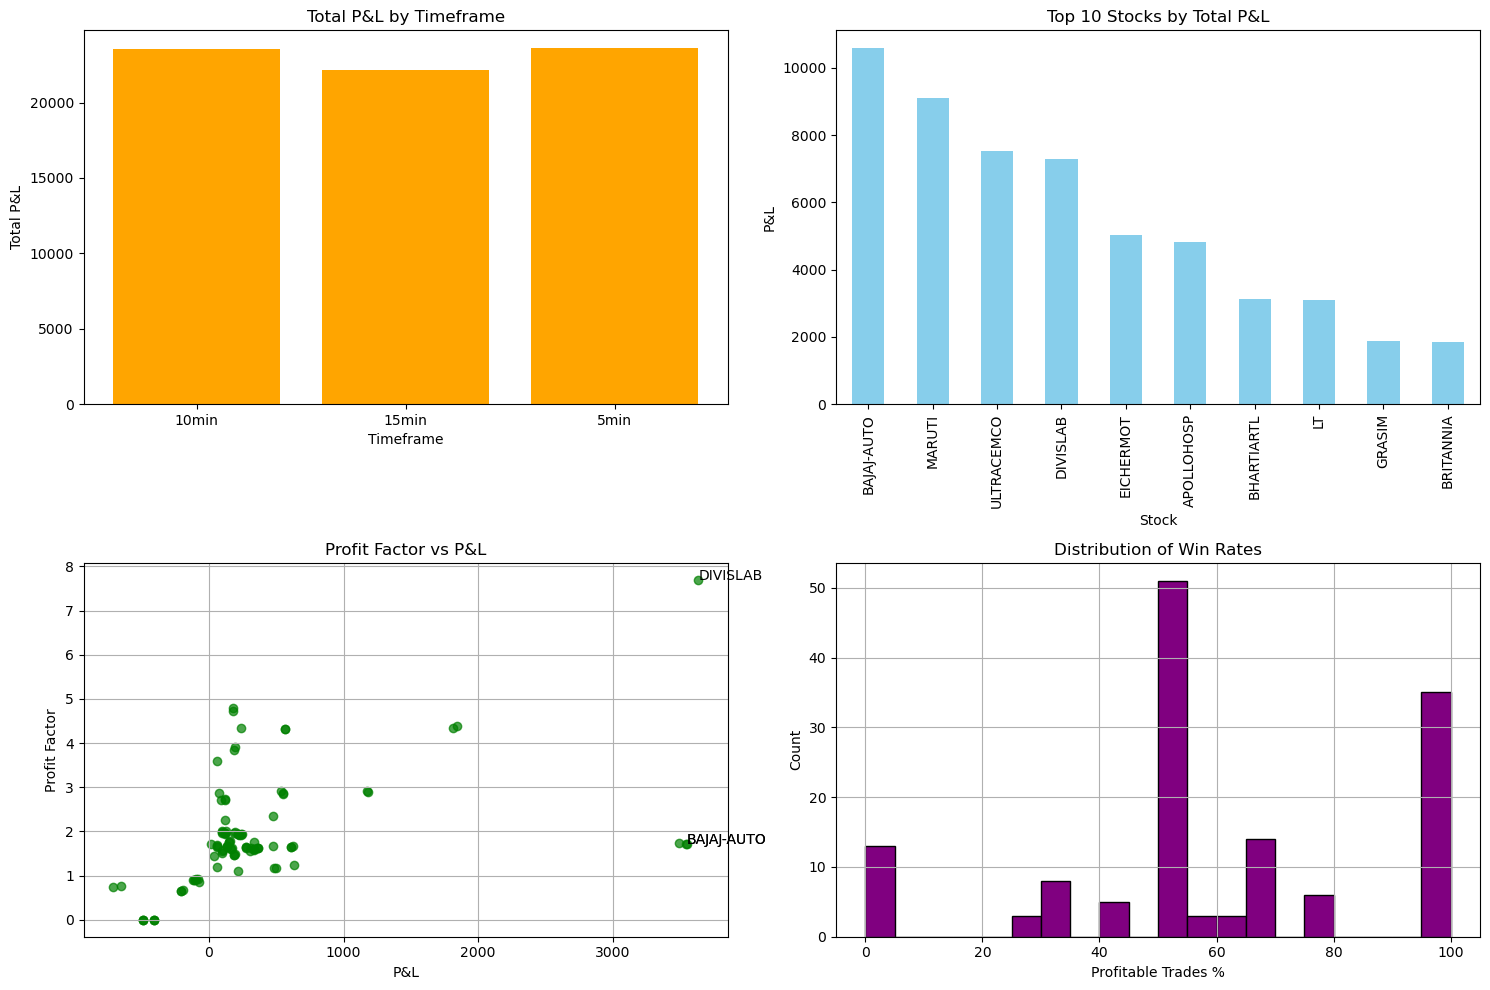

In [3]:
import matplotlib.pyplot as plt

# Make sure summary & agg_tf exist
summary = pd.read_csv(r"S:\stock project\outputs\summary.csv")
agg_tf = summary.groupby("Timeframe", as_index=False).agg({
    "P&L":"sum",
    "Max Drawdown":"min",
    "Number of Trades":"sum",
    "Profitable Trades %":"mean",
    "Profit Factor":"mean"
})

fig, axes = plt.subplots(2, 2, figsize=(15,10))

# 1. Total P&L by Timeframe
axes[0,0].bar(agg_tf["Timeframe"], agg_tf["P&L"], color="orange")
axes[0,0].set_title("Total P&L by Timeframe")
axes[0,0].set_xlabel("Timeframe")
axes[0,0].set_ylabel("Total P&L")

# 2. Top 10 Stocks by P&L
top10 = summary.groupby("Stock")["P&L"].sum().sort_values(ascending=False).head(10)
top10.plot(kind="bar", ax=axes[0,1], color="skyblue")
axes[0,1].set_title("Top 10 Stocks by Total P&L")
axes[0,1].set_ylabel("P&L")

# 3. Profit Factor vs P&L scatter
axes[1,0].scatter(summary["P&L"], summary["Profit Factor"], alpha=0.7, color="green")
axes[1,0].set_title("Profit Factor vs P&L")
axes[1,0].set_xlabel("P&L")
axes[1,0].set_ylabel("Profit Factor")
axes[1,0].grid(True)

# Annotate top performers
for i, row in summary.iterrows():
    if row["P&L"] > summary["P&L"].quantile(0.98):  # top 2%
        axes[1,0].annotate(row["Stock"], (row["P&L"], row["Profit Factor"]))

# 4. Win Rate Distribution
summary["Profitable Trades %"].hist(bins=20, ax=axes[1,1], color="purple", edgecolor="black")
axes[1,1].set_title("Distribution of Win Rates")
axes[1,1].set_xlabel("Profitable Trades %")
axes[1,1].set_ylabel("Count")

plt.tight_layout()
plt.show()
